In [7]:
"""Generate ringdown templates in the time and perform parameter estimation on them.
"""

'Generate ringdown templates in the time and perform parameter estimation on them.\n'

In [20]:
#Import relevant modules, import data and all that
import time
import numpy as np
import corner
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
from configparser import ConfigParser
plt.rcParams.update({'font.size': 16.5})

from multiprocessing import Pool
from pycbc.pool import choose_pool
import random
import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal
from dynesty import utils as dyfunc
import os
import argparse
import scipy.optimize as optimization
from scipy.optimize import minimize
import rdown as rd
import rdown_pe as rd_pe
import rdown_utilities as rd_ut
import read_data as rdata
from pycbc.waveform import ringdown as pycbcrd
from pycbc.psd import aLIGOZeroDetHighPower
import qnm

In [30]:
linspace=np.linspace(0,0.999,1000)
grav_220 = qnm.modes_cache(s=-1,l=2,m=-2,n=0)
vec_modes=np.array([grav_220(a=i)[0] for i in linspace])

In [31]:
vals=np.stack((linspace,vec_modes.real,vec_modes.imag)).T
np.savetxt('/work/francisco.jimenez/venv_sc/pycbc/pycbc/QNM_12-2.txt',vals, fmt='%.18e')

In [26]:
from pycbc.waveform import  get_td_from_final_mass_spin
from pycbc import conversions
def t_to_Phys(tau,M):
    """ It converts NR times to physical units in [s].
    """  
    return M*4.924452206270684e-06*tau

def f_to_Phys(f,M):
    """ It converts NR frequencies to physical units in [Hz].
    """  
    return 203068.27198497794/M*f

In [21]:
this_folder="/work/francisco.jimenez/venv_sc/pycbc/pycbc/"
_cache = dict()

In [ ]:
%%time
s,l,m=3,2,2
spin=0.7
mass=100
file=this_folder+'QNM_{}{}{}.txt'.format(s,l,m)
if file not in _cache:
    _cache[file] = np.loadtxt(file,dtype=float)
spin_list=_cache[file][:,0]
boolean=spin_list>=spin
mode=_cache[file][boolean][0]       
freq=f_to_Phys(mode[1]/(2*np.pi),mass)
tau=t_to_Phys(-1/mode[2],mass)

CPU times: user 898 µs, sys: 313 µs, total: 1.21 ms
Wall time: 769 µs


In [ ]:
%%time
conversions.qnmfreq_no_tensor(70, 0.8, 2, 2, 0,s=-2)

CPU times: user 112 µs, sys: 36 µs, total: 148 µs
Wall time: 154 µs


(270.5096457985752, 0.004558857759937646)

In [2]:
## Loading and running data tested with NR data
## Loading and running data tested with Mock data

In [3]:
# Cell that calls the arguments from your 'config.ini' file. 
try:
    parser = argparse.ArgumentParser(description="Simple argument parser")
    parser.add_argument("-c", action="store", dest="config_file")
    result = parser.parse_args()
    config_file=result.config_file
    parser = ConfigParser()
    parser.read(config_file)
    parser.sections()
except SystemExit: 
    parser = ConfigParser()
    parser.read('config_fixed_n1_m_af_a_b.ini')
    parser.sections()
    pass

usage: ipykernel_launcher.py [-h] [-c CONFIG_FILE]
ipykernel_launcher.py: error: unrecognized arguments: -f /work/francisco.jimenez/.local/share/jupyter/runtime/kernel-8ff33416-d021-4919-a2c3-8eeed4ac7bbe.json


In [4]:
# Load variables from config file
(rootpath, simulation_path_1,simulation_path_2, metadata_file , simulation_number, output_folder,
 export, overwrite, sampler,nr_code, nbcores,tshift,tend,t_align,
 nmax , npoints, model, error_str, fitnoise, l_int, index_mass,index_spin,
error_type, error_val, af, mf,tau_var_str,nm_mock,downfactor,likelihood)=rdata.read_config_file(parser)

In [5]:
simulation_path_1,output_folder

('/work/francisco.jimenez/SXS/data/SXS_BBH_0559/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5',
 'run_1_m_af_a_b_0559')

In [6]:
dim = nmax+1
ndim = 4*dim
numbins = 32 #corner plot parameter - how many bins you want
    
print('model:',model)
print('nmax:',nmax)
print('nlive points:',npoints)
print('cores:',nbcores)
print('nm_mock:',nm_mock)
print('tshift:',tshift)
print('error:', error_str)
print('error value:',error_val)
print('export:',export)
print('nr code:',nr_code)
print('fit noise:',fitnoise)
print('likelihood:',likelihood)

model: w-tau-fixed-m-af-a-b
nmax: 1
nlive points: 2000
cores: 128
nm_mock: None
tshift: 0.0
error: False
error value: 0
export: True
nr code: SXS
fit noise: False
likelihood: log_likelihood


In [7]:
# Create output directories 
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
    print("Directory " , output_folder ,  " Created ")

if nr_code == 'Mock-data':   
    nm_mock_str = 'rec_with'+parser.get('rd-mock-parameters','nm_mock')+'_'
else:
    nm_mock_str=''
        
if error_str:
    output_folder_1=(output_folder+'/'+model+'-nmax'+str(nmax)+'_'+nm_mock_str+str(error_str)+'_'+str(error_type)+'_fitnoise_'+str(fitnoise))
else:
    output_folder_1=output_folder+'/'+model+'-nmax'+str(nmax)+'_'+nm_mock_str+str(error_str)+'_'+'fitnoise_'+str(fitnoise)

if not os.path.exists(output_folder_1):
    os.mkdir(output_folder_1)
    print("Directory " , output_folder_1 ,  " Created ")

In [8]:
# Define output files 
pars = [simulation_number,model,nmax,tshift,npoints]
corner_plot = rdata.create_output_files(output_folder_1,pars,'corner_plot')
corner_plot_extra = rdata.create_output_files(output_folder_1,pars,'corner_plot_extra')
diagnosis_plot = rdata.create_output_files(output_folder_1,pars,'diagnosis')
fit_plot = rdata.create_output_files(output_folder_1,pars,'fit')
samples_file = rdata.create_output_files(output_folder_1,pars,'post_samples')
results_file = rdata.create_output_files(output_folder_1,pars,'sampler_results')
sumary_data = rdata.create_output_files(output_folder_1,pars,'log_z')
best_data = rdata.create_output_files(output_folder_1,pars,'best_vals')

files = [corner_plot,corner_plot_extra,diagnosis_plot,fit_plot,samples_file,results_file,sumary_data,best_data]

In [9]:
# Remove old files if overwrite = True
if overwrite:
    rd_ut.rm_files(files)

In [10]:
#Load NR data, align in time and resize. Plot real part and amplitude. Finally compute the mismatch and the snr estimate
data = rdata.read_data(nr_code,simulation_path_1,RD=True,tshift=tshift,tend = tend,metadata_file=metadata_file,parser=parser)
if error_str:
    data_l = rdata.read_data(nr_code,simulation_path_2,RD=True,tshift=tshift,tend = tend,metadata_file=metadata_file,parser=parser)
    data_r, data_lr = rdata.nr_resize(data,data_l,tshift=tshift,tend=tend)
else:
    data_r=data
times_rd = data_r[:,0]

In [11]:
# Phase alignement
if parser.has_option('rd-model','phase_alignment'):
    phase_alignment=eval(parser.get('rd-model','phase_alignment'))    
else:
    phase_alignment=False
    
if phase_alignment:
    datar_al = rdata.phase_align(data_r,data_lr)
    gwdatanew5 = data_lr[:,1]
    gwdatanew = datar_al[:,1]    
    timesrd_final = datar_al[:,0]
    mismatch=1-rd_ut.EasyMatchT(timesrd_final,gwdatanew,gwdatanew5,tshift,tend)
    error=np.sqrt(2*mismatch)
    print('error estimate:',error)
    print('mismatch:', mismatch)
    print('snr:', rd_ut.EasySNRT(timesrd_final,gwdatanew,gwdatanew5,tshift,tend)/error)
    if error_str:
        error = np.sqrt(gwdatanew*gwdatanew-2*gwdatanew*gwdatanew5+gwdatanew5*gwdatanew5)
        error_est=np.sqrt(error.imag**2+error.real**2)
    else :
        error = 1 
else:
    datar_al = data_r
    timesrd_final = datar_al[:,0]

In [12]:
# Likelihood, physical units and others
if parser.has_option('rd-model','physical_units'):
    physical_units=eval(parser.get('rd-model','physical_units'))

if parser.has_option('rd-model','initial_mass'):
    initial_mass=np.float(parser.get('rd-model','initial_mass'))
    if not physical_units:
        initial_mass = 1

if parser.has_option('rd-model','snr'):
    snr = np.float(parser.get('rd-model','snr') )

/work/francisco.jimenez/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/work/francisco.jimenez/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


In [13]:
# Get a first estimate by trying to fit the data.
# Define your noise depending on the noise configuration. Load priors and setup the likelihood with rd_pe.Ringdown_PE. 
if error_str and error_val==0:
    error_final = error_est
    norm_factor = 100*len(error_final)/2*np.log(2*np.pi)
elif error_str and error_val!=0:
    datar_al[:,1]+=random.uniform(0, error_val)
    datar_al[:,1]+=1j*random.uniform(0, error_val)
    error_tsh = error_val
    error_final=(error_tsh.real**2+error_tsh.imag**2)
    norm_factor = 0
else:
    error_tsh=1
    error_final=(error_tsh.real**2+error_tsh.imag**2)/1000
    norm_factor = 0
    
if parser.has_option('setup','qnm_model'):
    qnm_model='berti'
    rdownfolders=np.asarray([rootpath+'/RDmodes/l2/n'+str(i+1)+'l2m2.dat' for i in range(nmax+1)])
    rdowndata = [np.loadtxt(rdownfolders[i]).T for i in range(len(rdownfolders))]
else:
    qnm_model='qnm'

priors = rd_pe.load_priors(model,parser,nmax,fitnoise=fitnoise)
rdown=rd.Ringdown_Spectrum(mf,af,2,2,n=nmax,s=-2,time=timesrd_final, rdowndata = rdowndata,model=model,
                           physical_units=physical_units,total_mass = initial_mass)
rdown_pe = rd_pe.Ringdown_PE(rdown,datar_al,dim,priors,errors2=error_final,norm_factor=norm_factor,
                            model=model,l_int=l_int,
                            physical_units=physical_units,sigma=snr)

In [14]:
if likelihood == 'log_likelihood':
    rdowlike=rdown_pe.log_likelihood
elif likelihood == 'log_likelihood_fd':
    rdowlike=rdown_pe.log_likelihood_fd

#nll: likelihood distribution
#rdowlike: name of func that loads likelihood
#initial: array of initial parameters 0.1ecc 10hz
#bounds are priors
#look for best fit parameters, compare to dynesty

nll = lambda *args: -rdowlike(*args)
if model == 'w-tau-fixed-m-af':
    if fitnoise:
        initial = np.concatenate((np.ones(2*dim),[0.8,0.9,1]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
    else:
        initial = np.concatenate((np.ones(2*dim),[0.8,0.9]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
        
if model == 'w-tau-fixed-m-af-a-b':
    if fitnoise:
        initial = np.concatenate((np.ones(2*dim),[0,0,0.8,0.9,1]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
    else:
        initial = np.concatenate((np.ones(2*dim),[0,0,0.8,0.9]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
elif model == 'w-tau-fixed-m-af-vary-tp':
    if fitnoise:
        initial = np.concatenate((np.ones(4*dim),[0.8,0.9,1]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
    else:
        initial = np.concatenate((np.ones(4*dim),[0.8,0.9]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
elif model == 'w-tau-fixed':
    if fitnoise:
        initial =  np.concatenate((np.ones(2*dim),[0.2]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
    else:
        initial = np.ones(2*dim)
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
else:
    if fitnoise:
        initial = np.concatenate((np.ones(ndim),[1]))
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
    else: 
        initial = np.ones(ndim)
        soln = minimize(nll, initial,bounds=priors)
        vars_ml=soln.x
print("best fit pars from fit: ",vars_ml)

best fit pars from fit:  [1.  1.  1.  1.  0.  0.  0.8 0.9]


/work/francisco.jimenez/sio/git/rdstackingproject/code_new/rdown.py:193: RuntimeWarning: divide by zero encountered in true_divide
  ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-self.time/tau_m_a[i]) * (np.cos(w_m_a[i]*self.time)-1j*np.sin(w_m_a[i]*self.time))
/work/francisco.jimenez/sio/git/rdstackingproject/code_new/rdown.py:193: RuntimeWarning: invalid value encountered in true_divide
  ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-self.time/tau_m_a[i]) * (np.cos(w_m_a[i]*self.time)-1j*np.sin(w_m_a[i]*self.time))
/work/francisco.jimenez/venv/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [15]:
pool = choose_pool(nbcores)
pool.size=nbcores

start = time.process_time()
f2=dynesty.NestedSampler(rdowlike,rdown_pe.prior_transform, len(priors), nlive=npoints,sample=sampler,pool=pool)
if parser.has_option('setup','dlogz'):
    dlogz=np.float(parser.get('setup','dlogz'))    
    f2.run_nested(dlogz=dlogz,print_progress=True)
else:
    f2.run_nested(print_progress=True)

print(time.process_time() - start)

/work/francisco.jimenez/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
46321it [21:33, 72.83it/s, bound: 202 | nc: 25 | ncall: 1099889 | eff(%):  4.211 | loglstar:   -inf < -124.987 <    inf | logz: -151.393 +/-  0.159 | dlogz: 88.712 >  0.100]     /work/francisco.jimenez/venv/lib/python3.7/site-packages/dynesty/sampling.py:243: UserWarning: Random walk proposals appear to be extremely inefficient. Adjusting the scale-factor accordingly.
  warnings.warn("Random walk proposals appear to be "
/work/francisco.jimenez/venv/lib/python3.7/site-packages/dynesty/sampling.py:243: UserWarning: Random walk

1812.350593477


In [16]:
res = f2.results
res.samples_u.shape
res.summary()
samps=f2.results.samples
postsamps = rd_ut.posterior_samples(f2)
samps_tr=np.transpose(samps)
half_points=int(round((len(samps_tr[0])/1.25)))
evidence = res.logz[-1]
evidence_error = res.logzerr[-1]
if export:
    rd_ut.save_object(res, results_file)

Summary
nlive: 2000
niter: 81787
ncall: 2471507
eff(%):  3.390
logz: -57.453 +/-  0.190


In [47]:
postsamps[-1]

array([ 0.44186447,  0.74581205,  4.40467217,  1.76182001, -0.20820833,
        0.33688189,  1.11986213,  0.87558093])

In [17]:
postsamps[-1]

array([ 0.42865053,  0.73716031,  4.42926515,  1.7827928 , -0.21116414,
        0.34660738,  1.1259721 ,  0.88060297])

In [ ]:
postsamps[-1]

array([ 0.44770287,  0.76055559,  4.44303461,  1.77424337, -0.2069439 ,
        0.36932556,  1.10955705,  0.87125853])

In [18]:
pars = nmax,model,samps_tr, half_points
npamps = rd_ut.get_best_amps(pars,parser=parser,nr_code=nr_code)

In [19]:
if export:
    pars = simulation_number, nmax, tshift, evidence, evidence_error
    rd_ut.export_logz_files(sumary_data,pars)

In [20]:
import importlib
importlib.reload(rd_ut)

labels = rd_ut.define_labels(dim,model,fitnoise)
if export:
    pars = tshift, len(priors), labels 
    rd_ut.export_bestvals_files(best_data,postsamps,pars)

In [21]:
w, tau = rdown.QNM_spectrum(mf, af)
pars = w, tau, mf, af, npamps 
truths = rd_ut.get_truths(model,pars,fitnoise)
labels.shape

(8,)

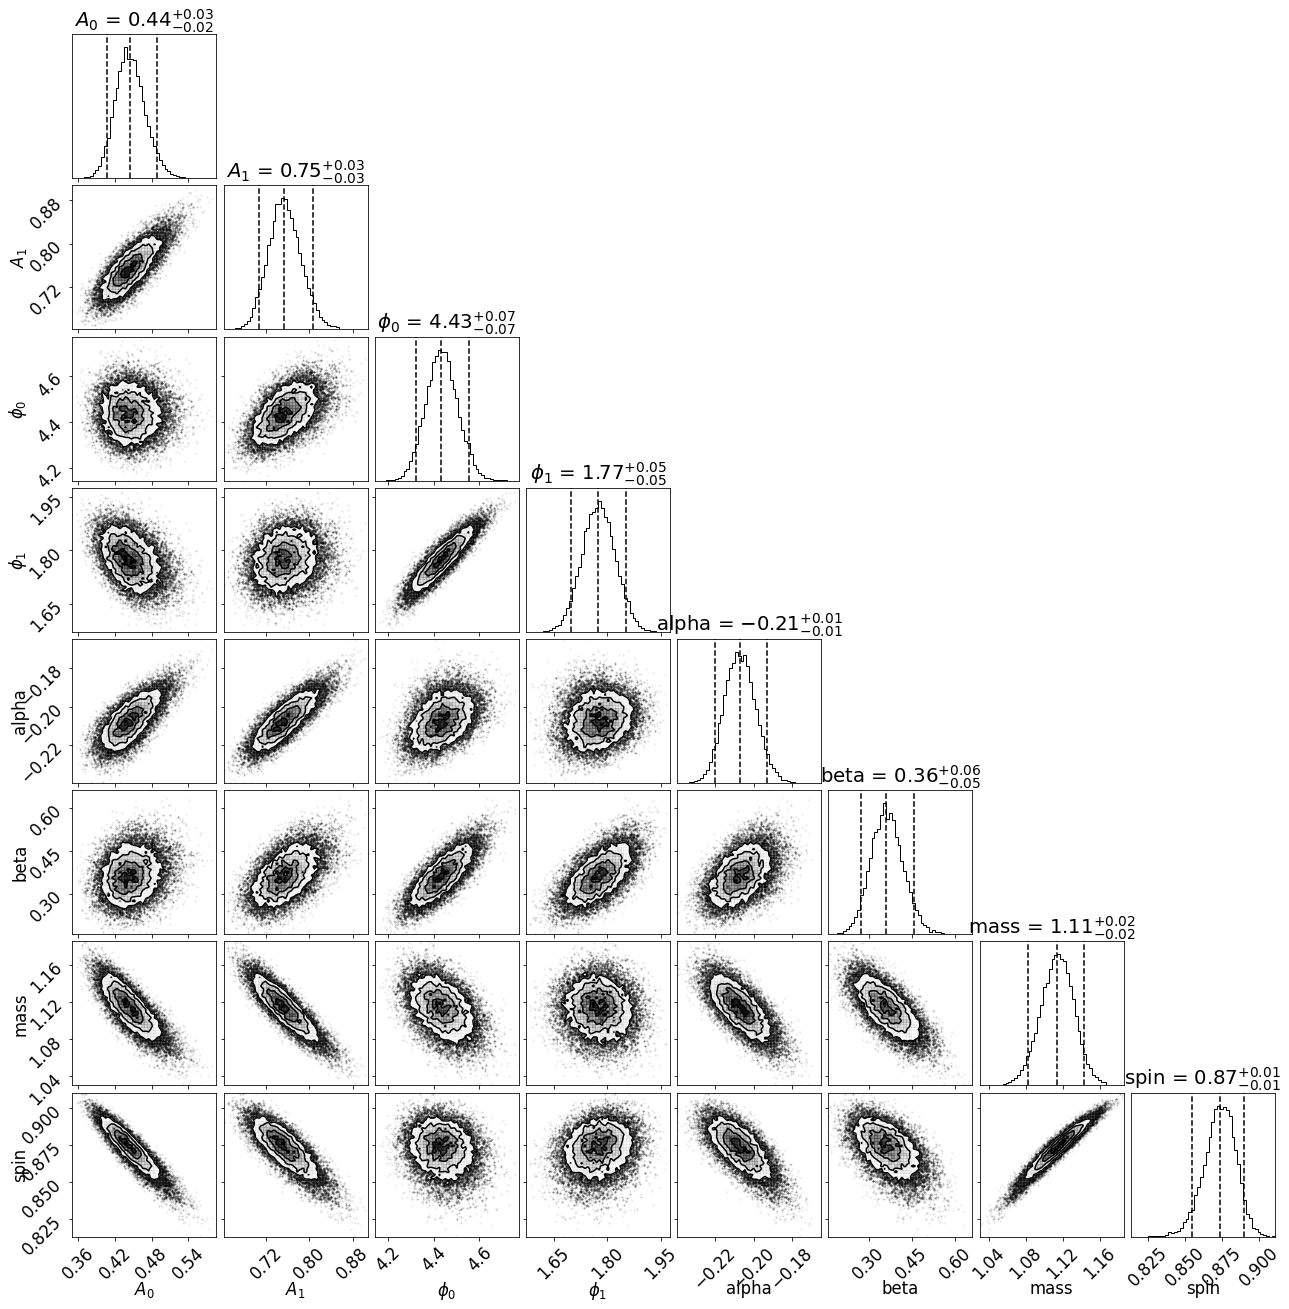

In [22]:
#fg=corner.corner(postsamps,quantiles=[0.05,0.5,0.95],show_titles=True,max_n_ticks = 4,bins=50,truths=truths,labels=labels,truth_color='red')
labels = rd_ut.define_labels(dim,model,fitnoise)
fg=corner.corner(postsamps,quantiles=[0.05,0.5,0.95],show_titles=True,max_n_ticks = 4,bins=50,labels=labels,truth_color='red')

plt.show()
if export:
    fg.savefig(corner_plot, format = 'png', bbox_inches = 'tight')

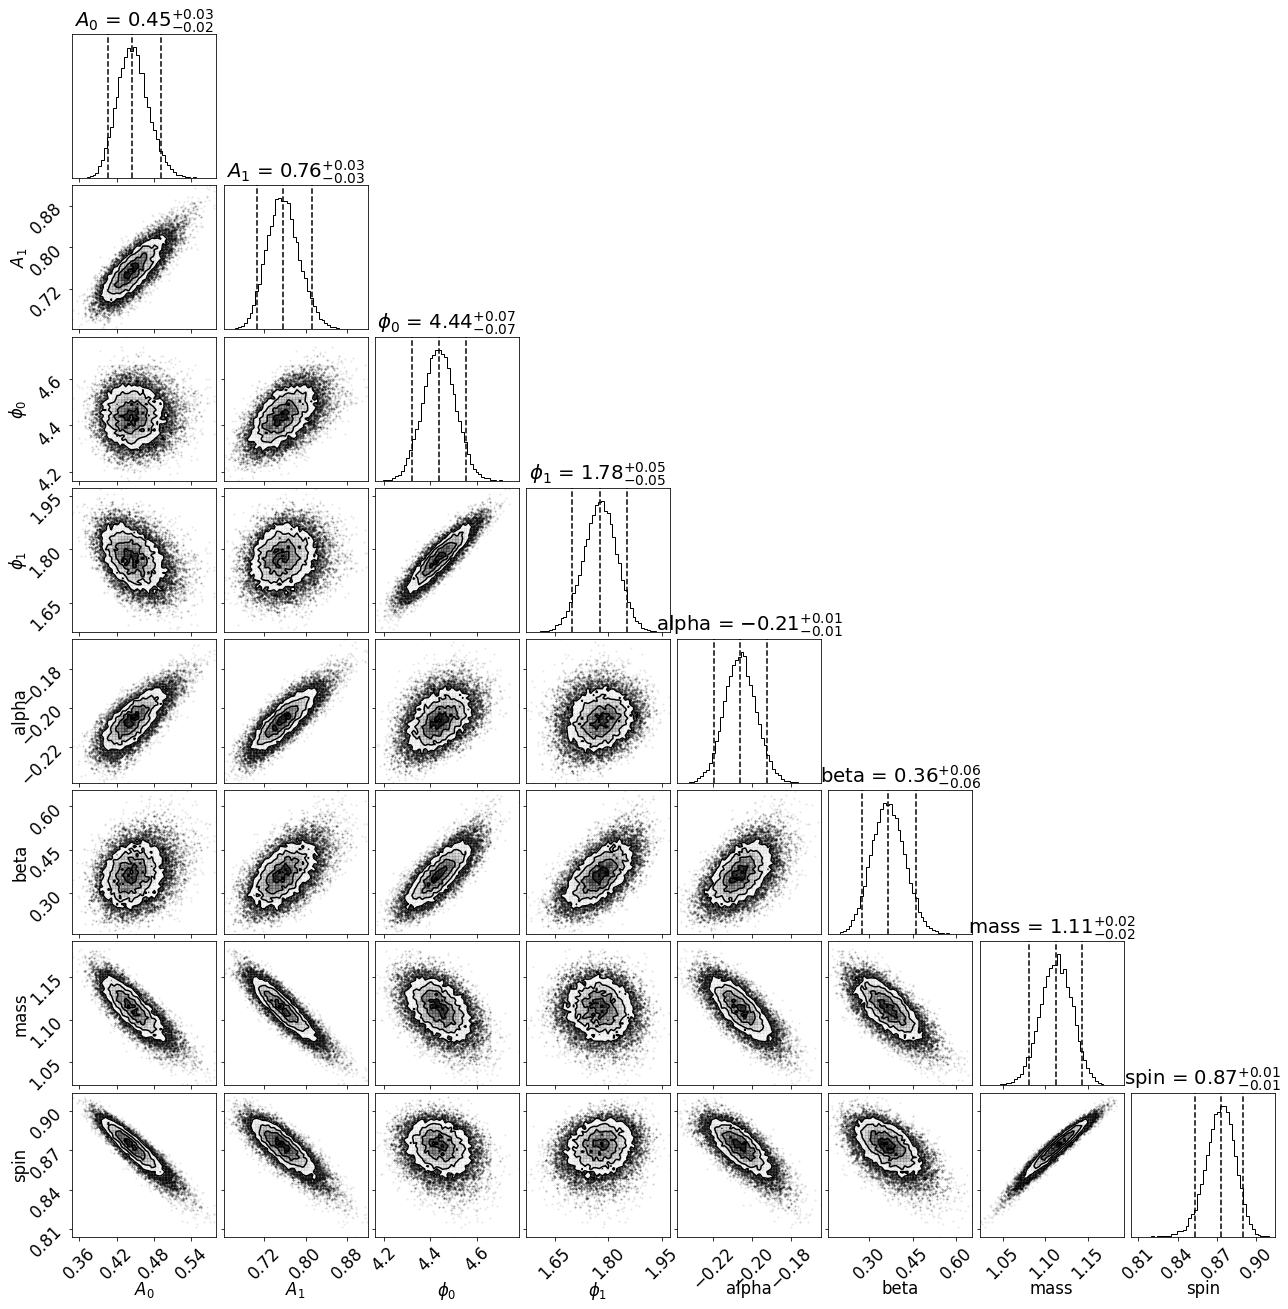

In [46]:
#fg=corner.corner(postsamps,quantiles=[0.05,0.5,0.95],show_titles=True,max_n_ticks = 4,bins=50,truths=truths,labels=labels,truth_color='red')
labels = rd_ut.define_labels(dim,model,fitnoise)
fg=corner.corner(postsamps,quantiles=[0.05,0.5,0.95],show_titles=True,max_n_ticks = 4,bins=50,labels=labels,truth_color='red')

plt.show()
if export:
    fg.savefig(corner_plot, format = 'png', bbox_inches = 'tight')

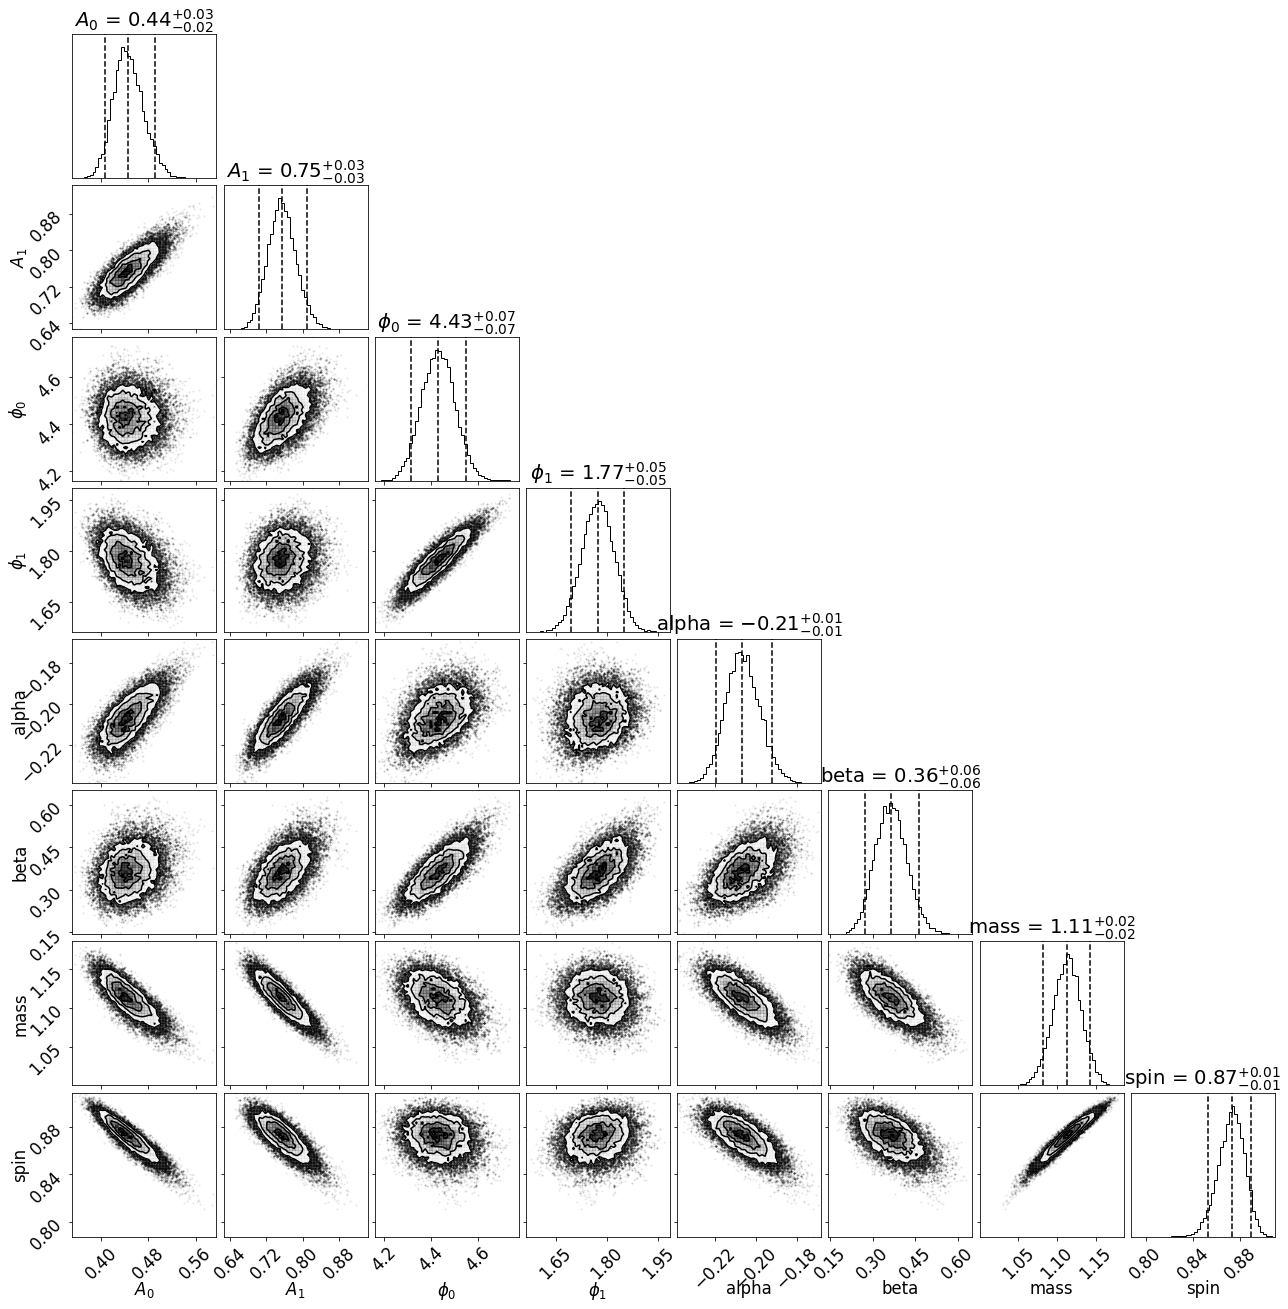

In [ ]:
#fg=corner.corner(postsamps,quantiles=[0.05,0.5,0.95],show_titles=True,max_n_ticks = 4,bins=50,truths=truths,labels=labels,truth_color='red')
labels = rd_ut.define_labels(dim,model,fitnoise)
fg=corner.corner(postsamps,quantiles=[0.05,0.5,0.95],show_titles=True,max_n_ticks = 4,bins=50,labels=labels,truth_color='red')

plt.show()
if export:
    fg.savefig(corner_plot, format = 'png', bbox_inches = 'tight')

In [ ]:
#lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(res)
fig.tight_layout()
if export:
    fig.savefig(diagnosis_plot, format = 'png', dpi = 384, bbox_inches = 'tight')

In [ ]:
if export:
    dict = {'w-tau':rdown.rd_model_wtau , 'w-q': rdown.rd_model_wq, 'w-tau-fixed':rdown.rd_model_wtau_fixed,'w-tau-fixed-m-af': rdown.rd_model_wtau_m_af,'w-tau-fixed-m-af-a-b': rdown.rd_model_wtau_m_af_a_b}
    figband = plt.figure(figsize = (12, 9))
    plt.plot(datar_al[:,0].real,datar_al[:,1].real, "green", alpha=0.9, lw=3, label=r'$res_{240}$')
    onesig_bounds = np.array([np.percentile(postsamps[:, i], [5, 95]) for i in range(len(postsamps[0]))]).T
    samples_1sigma = filter(lambda sample: np.all(onesig_bounds[0] <= sample) and np.all(sample <= onesig_bounds[1]), postsamps)
    samples_1sigma_down = list(samples_1sigma)[::downfactor]
    for sample in samples_1sigma_down:
        plt.plot(datar_al[:,0].real, dict[model](sample).real, "r-", alpha=0.1, lw=1)
    plt.title(r'Comparison of the MC fit data and the $1-\sigma$ error band')
    plt.legend()
    plt.xlabel('t')
    plt.ylabel('h')
    plt.show()
    figband.savefig(fit_plot)